# Comparing ARIMA, Holt Winters Exponential Smoothing and FaceBook Prophet time series techniques  
Using sample data about restaurant visitors, the above techniques are compared. EDA shows the presence of trend, seasonality and the effect of holidays. ARIMA has a lot of theory and this is explored in some detail. For Holt Winters, parameters learned include error (α), trend (β), trend damping (ϕ), seasonality (γ), initial level (l_0), and initial trend (b_0). To leverage its' ability to deal with multiple seasonalities (weekly, monthly, annual) and shifting trends, with little manual tuning, the FB Prophet technique is used.

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from matplotlib import pyplot as plt

# Load specific forecasting tools
from statsmodels.tsa.stattools import adfuller                  # stationarity test
from statsmodels.tsa.seasonal import seasonal_decompose         # ETS decomposition plots
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf    # determining (p,q) orders
from pmdarima import auto_arima                                 # determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX          # time series modelling
from statsmodels.tools.eval_measures import rmse                # metric

from statsmodels.tsa.exponential_smoothing.ets import ETSModel  # ETS modeling for Holt Winters 

from prophet import Prophet                                     # FB Prophet

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
df = pd.read_csv('/home/bala/Docs/Learning/RestaurantVisitors/RestaurantVisitors.csv',index_col='date',parse_dates=True)
#set the frequency
df.index.freq = 'D' 
#ordering to intuitively understand weekly seasonality
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
df['weekday'] = df['weekday'].astype(cat_type)

In [3]:
#American holidays/ data set
df['holiday_name'].unique()

array(["New Year's Day", 'na', 'Martin Luther King Day', 'Groundhog Day',
       "Valentine's Day", 'Presidents Day', "St. Patrick's Day",
       'Good Friday', 'Easter', 'Easter Monday', 'Cinco de Mayo',
       "Mother's Day", 'Memorial Day', "Father's Day", 'Independence Day',
       'Labor Day', 'Columbus Day', 'Halloween', "Veterans' Day",
       'Thanksgiving', 'Black Friday', 'Christmas Eve', 'Christmas Day',
       "New Year's Eve"], dtype=object)

In [4]:
#rows from 2017-04-23 are 'future' dates
df.iloc[-50:-35,]

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-12,Wednesday,0,na,44.0,2.0,15.0,28.0,89.0
2017-04-13,Thursday,0,na,19.0,12.0,12.0,27.0,70.0
2017-04-14,Friday,1,Good Friday,41.0,74.0,57.0,49.0,221.0
2017-04-15,Saturday,0,na,69.0,24.0,66.0,59.0,218.0
2017-04-16,Sunday,1,Easter,58.0,35.0,60.0,100.0,253.0
2017-04-17,Monday,1,Easter Monday,63.0,21.0,24.0,32.0,140.0
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0


In [5]:
#holiday information provided for 'future' dates as well - needed to use it as an exog variables
df_train = df.loc[:'2016-12-31']
print('df_train.shape: ', df_train.shape)
print(df_train.iloc[0,:])
print(df_train.iloc[-1,:])
print('*'*100)
df_val = df.loc['2017-01-01':'2017-04-22']
print('df_val.shape: ',df_val.shape)
print(df_val.iloc[0,:])
print(df_val.iloc[-1,:])
print('*'*100)
df_test = df.loc['2017-04-23':]
print('df_test.shape: ',df_test.shape)
print(df_test.iloc[0,:])
print(df_test.iloc[-1,:])

df_train.shape:  (366, 8)
weekday                 Friday
holiday                      1
holiday_name    New Year's Day
rest1                     65.0
rest2                     25.0
rest3                     67.0
rest4                    139.0
total                    296.0
Name: 2016-01-01 00:00:00, dtype: object
weekday               Saturday
holiday                      1
holiday_name    New Year's Eve
rest1                     88.0
rest2                     54.0
rest3                     57.0
rest4                    117.0
total                    316.0
Name: 2016-12-31 00:00:00, dtype: object
****************************************************************************************************
df_val.shape:  (112, 8)
weekday                 Sunday
holiday                      1
holiday_name    New Year's Day
rest1                     48.0
rest2                     43.0
rest3                     47.0
rest4                    118.0
total                    256.0
Name: 2017-01-01 00:00:

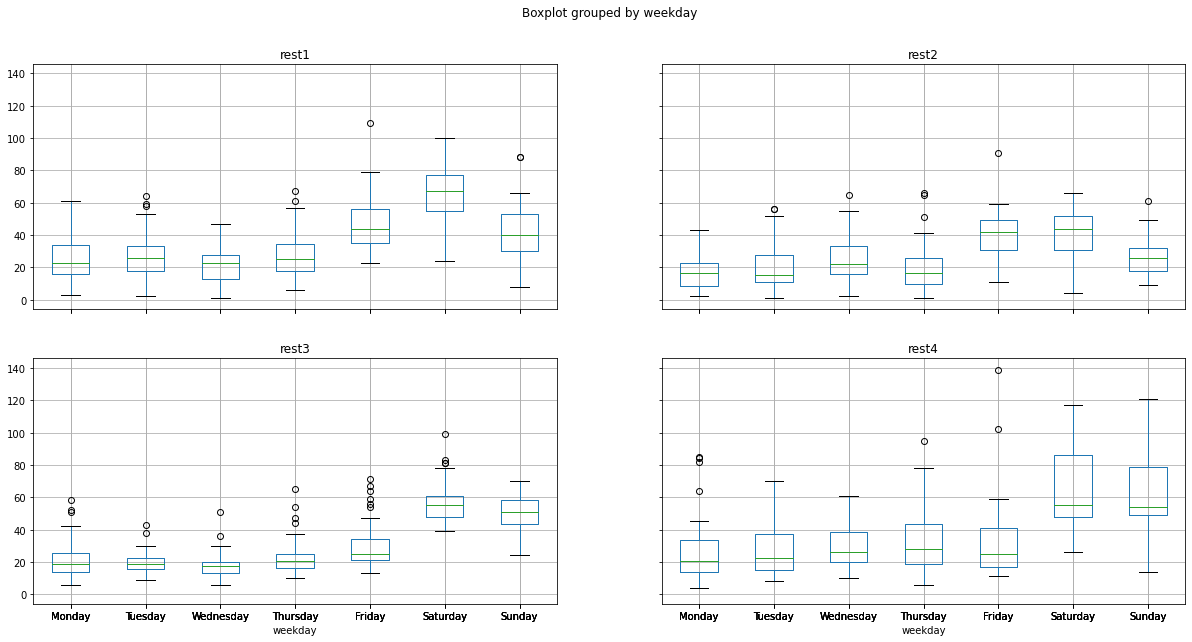

In [6]:
#individual restaurants showing weekly seasonality
df_train.boxplot(['rest1', 'rest2', 'rest3', 'rest4'],by='weekday', figsize=(20,10));

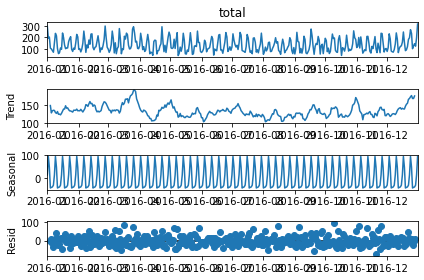

In [7]:
#validating this weekly seasonality using the total visitors across all 4 restaurants

#trend upswing towards the end of the year (holiday period) and around March (?)

result = seasonal_decompose(df_train['total'])
result.plot();

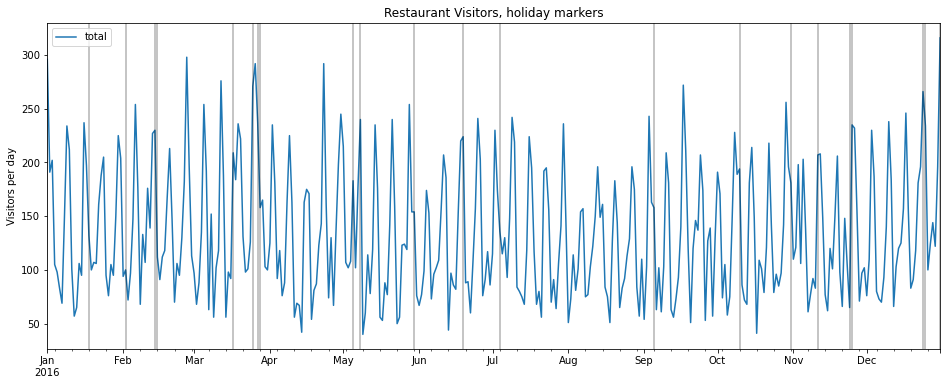

In [8]:
#Holidays have an impact, for example the year end period
title='Restaurant Visitors, holiday markers'
ylabel='Visitors per day'
xlabel=''

ax = df_train['total'].plot(legend=True,figsize=(16,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df_train.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

# ARIMA

## Manual determination of p,d,q and P,D,Q

In [9]:
#Stationarity/ need for differencing
adfuller(df_train['total'],autolag='AIC')

(-3.4219962134084354,
 0.01023149049071697,
 15,
 350,
 {'1%': -3.4491725955218655,
  '5%': -2.8698334971428574,
  '10%': -2.5711883591836733},
 3497.2609293249025)

## Differencing
'ADF test statistic','p-value','# lags used','# observations', 'critical values at 1, 5, and 10% significance
Null hypothesis - not stationary. Given low p-value, null hypothesis is rejected 
Suprising result, given the clear weekly seasonality. In any case, no differencing needed

<a href='https://otexts.com/fpp2/stationarity.html'> Hyndman Time Series Book</a>

## "AR Signature"

Ref: <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

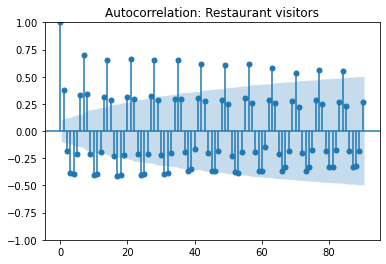

In [10]:
#Strong auto correlation 
title = 'Autocorrelation: Restaurant visitors'
lags = 90
plot_acf(df_train['total'],title=title,lags=lags);

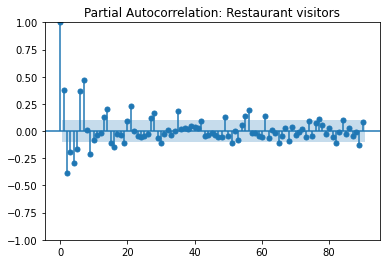

In [11]:
#much faster drop
title = 'Partial Autocorrelation: Restaurant visitors'
lags = 90
plot_pacf(df_train['total'],title=title,lags=lags);

## Finding p,d,q and P,D,Q using a standard module, <tt>pmdarima.auto_arima</tt> 

In [12]:
auto_arima(df_train['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  366
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -1811.044
Date:                             Wed, 03 May 2023   AIC                           3632.088
Time:                                     16:06:08   BIC                           3651.601
Sample:                                 01-01-2016   HQIC                          3639.842
                                      - 12-31-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3035      0.862      1.512      0.131      -0.386       2.993
ar.L1          0.1822      0.051      3.586      0.000       0.083       0.282
ar.S.L7        0.9880      0.007    136.121      0.000       0.974       1.002
ma.S.L7       -0.8224      0.049    -16.925      0.000      -0.918      -0.727
sigma2      1117.3889     76.303     14.644      0.000     967.837    1266.941
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.69
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.66
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fitting ARIMA model, with exogenous variable

In [13]:
model = SARIMAX(df_train['total'],exog=df_train['holiday'],order=(1,0,0),
        seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.59553D+00    |proj g|=  5.26516D-02

At iterate    5    f=  5.48614D+00    |proj g|=  7.49942D-03

At iterate   10    f=  5.47896D+00    |proj g|=  4.39736D-02

At iterate   15    f=  5.35704D+00    |proj g|=  1.77983D-01

At iterate   20    f=  5.31812D+00    |proj g|=  5.50613D-03

At iterate   25    f=  5.18815D+00    |proj g|=  2.09342D-01

At iterate   30    f=  5.00055D+00    |proj g|=  2.11326D-02

At iterate   35    f=  4.99856D+00    |proj g|=  8.46504D-03

At iterate   40    f=  4.97191D+00    |proj g|=  7.11729D-02

At iterate   45    f=  4.95829D+00    |proj g|=  2.13802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  366
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -1814.731
Date:                           Wed, 03 May 2023   AIC                           3639.462
Time:                                   16:06:09   BIC                           3658.975
Sample:                               01-01-2016   HQIC                          3647.216
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       68.6741      5.220     13.155      0.000      58.442      78.906
ar.L1          0.1786      0.055      3.223      0.001       0.070       0.287
ar.S.L7        0.5335      0.048     11.104      0.000       0.439       0.628
ar.S.L14       0.4413      0.048      9.213      0.000       0.347       0.535
sigma2      1123.1973     82.363     13.637      0.000     961.769    1284.626
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.72   Prob(JB):                         0.68
Heteroskedasticity (H):               0.94   Skew:                             0.11
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model assumptions and results interpretation  
1. Residuals are not correlated, i.e no signal remaining and only white noise (Ljung-Box)). Test fails but correlogram (ACF of residuals) shows small but statistically significant impact only 7 days out. So, acceptable shortcoming.   
2. Residuals have zero mean.  
3. Residuals do not have heteroskedasticity, i.e have constant variance. Again test fails. But Q-Q plot shows that the model is OK through most of its range and only fails at the extremes.  
4. Residuals are normally distributed (Jarque-Bera test comparing skew & kurtosis to that of a normal distribution). Test fails. But plots show the deviation is minor.

sigma2: Variance of the error term  

Sources: <a href='https://otexts.com/fpp2/residuals.html'>Hyndman</a>, <a href='https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/arima/interpret-the-results/key-results/?SID=117600'>Minitab</a>, <a href='https://www.statisticshowto.com/goldfeld-quandt-test/'>Goldfeld Quandt Test for homoskedasticity</a>, <a href='https://github.com/statsmodels/statsmodels/issues/2507#:%7E:text=The%20sigma2%20output%20in%20the,variance%20of%20the%20error%20term'>sigma2</a>


### Other metrics  

1. Maximum Likelihood Estimation (MLE): maximize L(y|X ; h), conditional probability of the output (y) given the input (X) given the modeling hypothesis (h). L is the likelihood function and h are the parameters beta0, beta1... betan. Log sums used in place of multiplication of small probabilities for each observation (We need the joint probability of all observations). Hence log likelihood function. Optimization is typically a minimization problem, so we minimize the negative log likelihood function which then measures the "cost" of the model.  
Source (Machine Learning Mastery): <a href='https://machinelearningmastery.com/what-is-maximum-likelihood-estimation-in-machine-learning/'>MLE</a>, <a href='https://machinelearningmastery.com/logistic-regression-with-maximum-likelihood-estimation/'>MLE for Machine Learning</a>  
  
2. Akaike Information Criterion (AIC): AIC = 2K - 2ln(L), where K is the number of independent variables used (+2) and L is the log-likelihood estimate. Used to compare models. Lower the AIC score, better the fit.   
Source: <a href='https://www.scribbr.com/statistics/akaike-information-criterion/'>AIC</a>
  
3. Bayesian Information Criterion (BIC): BIC = Kln(n) - 2ln(L). n is the number of observations. Similar to AIC, but different penalty for number of independent variables used.  
  
4. Hannan–Quinn Information Criterion (HQIC): HQIC = -2Lmax + 2Kln(ln(n)).  


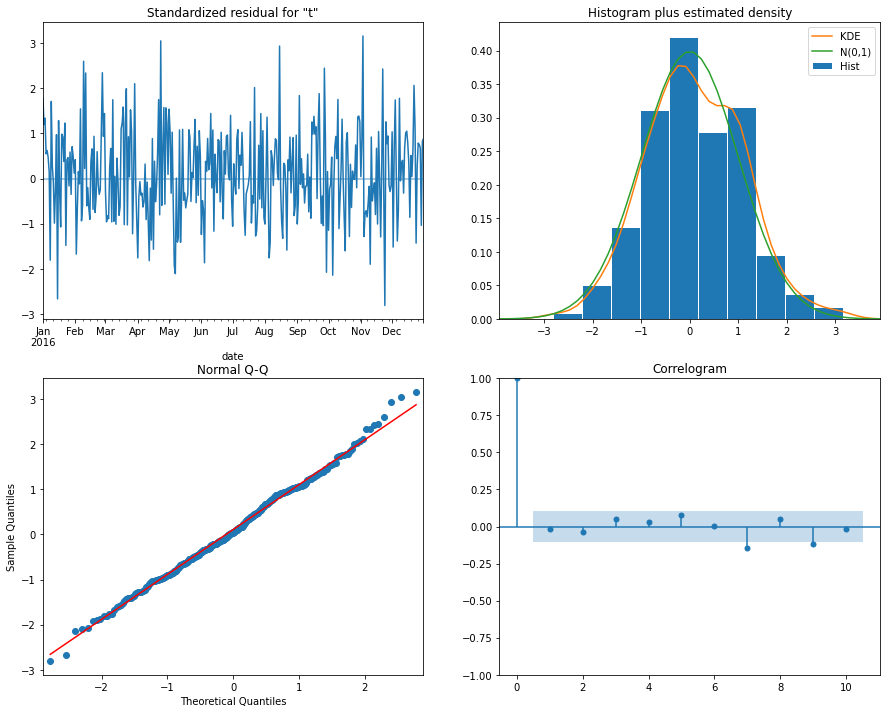

In [14]:
results.plot_diagnostics(figsize=(15, 12));

In [15]:
# Predictions
exog_forecast = df_val[['holiday']]  # requires two brackets to yield a shape of (35,1)
predict_ARIMA= results.predict(start=df_val.index[0], end=df_val.index[-1], exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Predictions')

## Holt Winters  

Exponential smoothing is a simpler technique and is applied to the same dataset below. The dataset has shown trend and weekly seasonality and these have been incorporated in the models. The parameters learned, for error (α), trend (β), trend damping (ϕ), seasonality (γ), initial level (l_0), and initial trend (b_0) are shown.    
  
The modeling excludes multiplicative trend, and combining additive error with multplicative seasonality, for reasons prescribed by Hyndman <a href='https://otexts.com/fpp3/taxonomy.html'>here</a> and <a href='https://otexts.com/fpp3/ets-estimation.html'>here</a> respectively.  

In [16]:
#model training
fit_ETS1 = ETSModel(df_train['total'], seasonal_periods=7, error='add', trend='add', seasonal='add', damped_trend = False).fit(disp=0)
fit_ETS2 = ETSModel(df_train['total'], seasonal_periods=7, error='add', trend='add', seasonal='add', damped_trend = True).fit(disp=0)
fit_ETS3 = ETSModel(df_train['total'], seasonal_periods=7, error='mul', trend='add', seasonal='mul', damped_trend = False).fit(disp=0)
fit_ETS4 = ETSModel(df_train['total'], seasonal_periods=7, error='mul', trend='add', seasonal='mul', damped_trend = True).fit(disp=0)

In [17]:
#learned parameters and metric. Note the stark difference in SSE between additive and multiplicative models above, on training data
results=pd.DataFrame(index=[r"α",r"β", r"ϕ",r"γ",r"l_0",r"b_0", r"SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damped_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results["AAA"]       = [fit_ETS1.params[p] for p in range(0,len(params))] + [fit_ETS1.sse]
results["AAdA"] = [fit_ETS2.params[p] for p in range(0,len(params))] + [fit_ETS2.sse]
results["MAM"]   = [fit_ETS3.params[p] for p in range(0,len(params))] + [fit_ETS3.sse]
results["MAdM"] = [fit_ETS4.params[p] for p in range(0,len(params))] + [fit_ETS4.sse]
results

,AAA,AAdA,MAM,MAdM
α,0.102182,0.112440,0.065625,0.065363
β,0.000010,0.000011,0.000007,0.000007
ϕ,0.000090,0.000089,0.000093,0.000093
γ,162.123555,0.800000,160.602406,0.800000
l_0,0.053658,224.009053,0.077107,216.601480
b_0,-47.997629,-21.964620,0.716156,-20.769640
SSE,374299.199961,367910.106438,27.187695,27.485330


The Holt Winters models are inferring low trend (β) and strong 7 day seasonality (γ) effect. Note the difference in the SSE on training data for additive and multiplicative models.

In [18]:
#predictions
pred_ETS1 = fit_ETS1.predict(start=df_val.index[0], end=df_val.index[-1])
pred_ETS2 = fit_ETS2.predict(start=df_val.index[0], end=df_val.index[-1])
pred_ETS3 = fit_ETS3.predict(start=df_val.index[0], end=df_val.index[-1])
pred_ETS4 = fit_ETS4.predict(start=df_val.index[0], end=df_val.index[-1])

# Prophet  

Facebook's Prophet has almost zero parameters to fiddle with, making the modeling task much simpler and easier to use. The time series decomposition by Prophet also shows strong weekly seasonality and holiday effect, and a changing trend component.

16:06:13 - cmdstanpy - INFO - Chain [1] start processing
16:06:13 - cmdstanpy - INFO - Chain [1] done processing


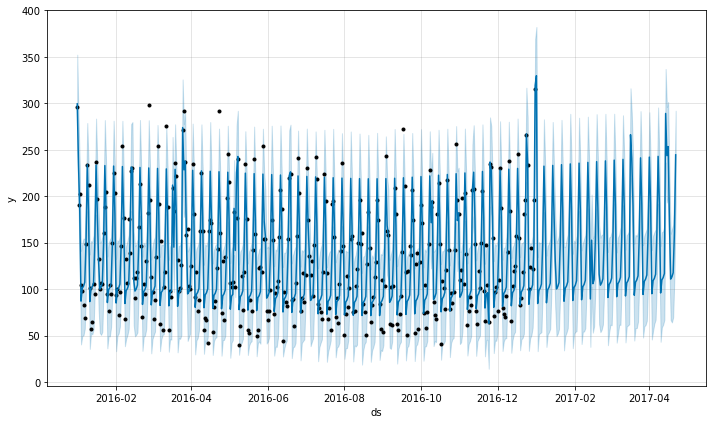

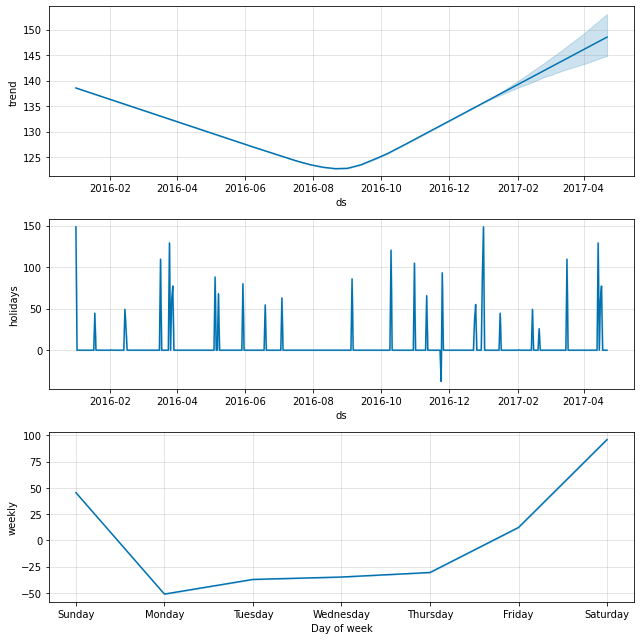

In [19]:
df_train = df_train.reset_index()
df_train = df_train.rename(columns={'date': 'ds','total': 'y'})
holidays = df.reset_index().rename(columns={'date': 'ds'})
holidays = holidays[holidays['holiday_name']!='na'][['ds','holiday_name']]
holidays = holidays.rename(columns={'holiday_name': 'holiday'})

my_model = Prophet(weekly_seasonality=True, interval_width=0.95, holidays=holidays)
my_model.fit(df_train)

future_dates = my_model.make_future_dataframe(periods=112, freq='D')
predict_Prophet = my_model.predict(future_dates)

my_model.plot(predict_Prophet, uncertainty=True)
my_model.plot_components(predict_Prophet)
plt.show()

In [20]:
#predictions
predict_Prophet_df = predict_Prophet.copy(deep=True)
predict_Prophet_df['ds'] = pd.to_datetime(predict_Prophet_df['ds'])
predict_Prophet_df = predict_Prophet.set_index('ds')

# Comparing modeling techniques  

In [21]:
#consolidated results
results_RMSE = pd.DataFrame({
    "NAME": ['ETS_AAA','ETS_AAdA', 'ETS_MAM', 'ETS_MAdM','ARIMA_EXOG','Prophet'],
    "RMSE": [round(rmse(df_val['total'], pred_ETS1),2), round(rmse(df_val['total'], pred_ETS2),2),
             round(rmse(df_val['total'], pred_ETS3),2), round(rmse(df_val['total'], pred_ETS4),2),
             round(rmse(df_val['total'], predict_ARIMA),2), round(rmse(df_val['total'], predict_Prophet_df.loc['2017-01-01':,'yhat']),2)],
    "Preds": [pred_ETS1, pred_ETS2,pred_ETS3, pred_ETS4, predict_ARIMA, predict_Prophet_df.loc['2017-01-01':,'yhat']]
})

results_RMSE = results_RMSE.sort_values('RMSE').reset_index(drop=True)
results_RMSE['Preds'].apply(lambda x: x.values)
results_RMSE[pred_ETS1.index] = pd.DataFrame(results_RMSE['Preds'].tolist(), index= results_RMSE.index)
results_RMSE = results_RMSE.T
new_header = results_RMSE.iloc[0] 
results_RMSE = results_RMSE[1:] 
results_RMSE.columns = new_header
results_RMSE = results_RMSE.drop('Preds')
list_for_val = np.append(0,df_val['total'].values)
results_RMSE['validation'] = list_for_val
results_RMSE


NAME,Prophet,ARIMA_EXOG,ETS_MAdM,ETS_MAM,ETS_AAdA,ETS_AAA,validation
RMSE,30.55,38.3,38.94,41.94,46.92,47.99,0.0
2017-01-01 00:00:00,329.798974,231.249932,201.97081,202.579526,214.138841,212.749415,256.0
2017-01-02 00:00:00,84.56707,91.039746,115.360593,115.781424,123.56877,122.095376,130.0
2017-01-03 00:00:00,98.652906,106.494601,107.186233,107.819821,126.014467,124.425145,144.0
2017-01-04 00:00:00,101.051757,128.920857,109.816117,110.483933,128.310331,126.71536,99.0
...,...,...,...,...,...,...,...
2017-04-18 00:00:00,110.834828,85.479906,107.187534,112.732391,126.017382,130.068243,91.0
2017-04-19 00:00:00,113.23368,102.033898,109.817184,115.515703,128.312663,132.358458,79.0
2017-04-20 00:00:00,117.660829,105.277836,124.424375,130.794317,135.666825,139.735552,90.0
2017-04-21 00:00:00,160.715564,147.085894,170.882455,182.759394,182.798537,187.786849,165.0


Note the close RMSE values of the exponential smoothing models  on unseen validation data. But the SSE on training data were drasticaly lower for the multiplicative models. Overfitting?

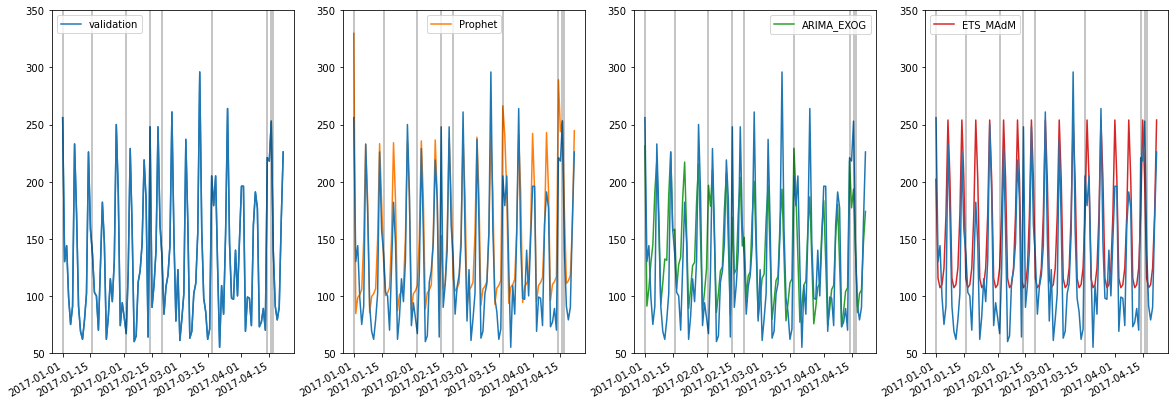

In [22]:
ax = results_RMSE.drop('RMSE').loc[:,['validation','Prophet', 'ARIMA_EXOG', 'ETS_MAdM']].plot(subplots=True, layout=(1,4), figsize=(20,7),ylim=(50,350))
for axe in ax[0]:
    axe.plot(results_RMSE.drop('RMSE').index, results_RMSE.drop('RMSE').loc[:,'validation'])
    for x in df_val.query('holiday==1').index: 
        axe.axvline(x=x, color='k', alpha = 0.3);

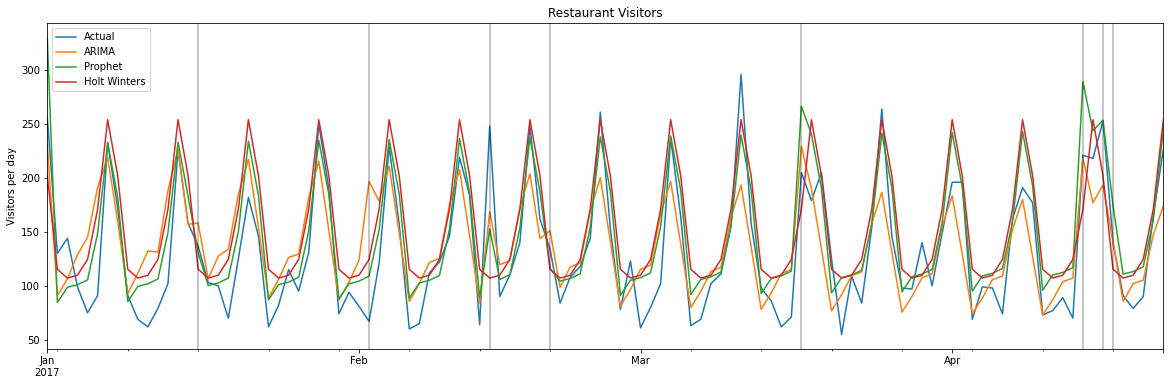

In [23]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df.rename(columns={'total':'Actual'}).loc['2017-01-01':'2017-04-22','Actual'].plot(legend=True,figsize=(20,6),title=title)
predict_ARIMA.rename('ARIMA').plot(legend=True)
predict_Prophet_df.rename(columns={'yhat':'Prophet'}).loc['2017-01-01':,'Prophet'].plot(legend=True)
pred_ETS4.rename('Holt Winters').plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df_val.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

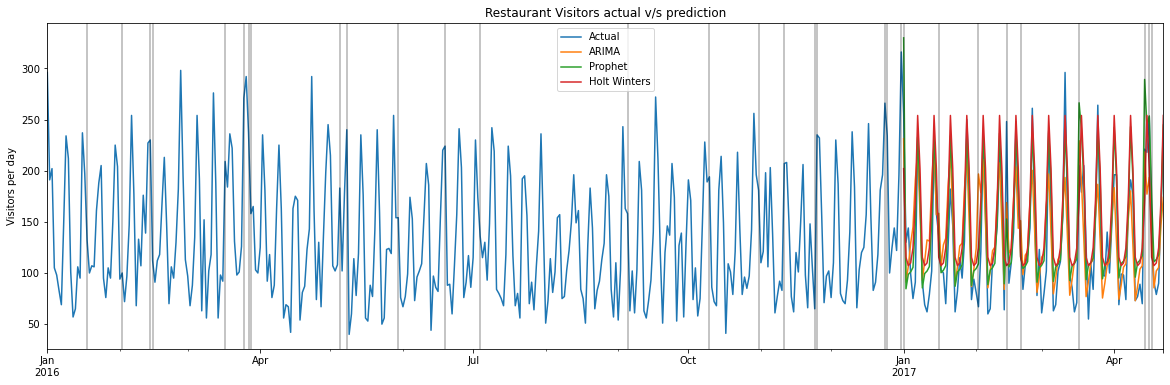

In [24]:
# Plot the forecast alongside historical values
title=f'Restaurant Visitors actual v/s prediction'
ylabel='Visitors per day'
xlabel=''

ax = df.rename(columns={'total':'Actual'}).loc[:'2017-04-22','Actual'].plot(legend=True,figsize=(20,6),title=title)
predict_ARIMA.rename('ARIMA').plot(legend=True)
predict_Prophet_df.rename(columns={'yhat':'Prophet'}).loc['2017-01-01':,'Prophet'].plot(legend=True)
pred_ETS4.rename('Holt Winters').plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.loc[:'2017-04-22'].query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

#

# Conclusion  
The unseen validation data shows demand varying widely from about 50 to about 250 visitors, with some additional spikes. The overall coverage/ tracking of these patterns is good across all the models.  

There is scope for improvement. Holt Winters does not account for holidays, and the trend tracking is weak (also seen in the low β parameter value). But it does consider weekly seasonality (γ) and produces steady estimates. ARIMA is a little more jittery, reasonably responding to changes in trend, 7 day seasonality, and holidays, but under-estimating at peaks (seen in the model Q-Q plot as well). Prophet seems to do a better job of estimating holiday demand but over-estimates at peaks. All the models over-estimate at the troughs. 
  
From a business use perspective, the over estimation at troughs could lead to wastage, like excess perishables ordered. Further, some capacity is easy to ramp up and down (like number of waiters) but others are difficult (like space for tables). Considering all this, a restaurant owner may prefer the steady Holt Winters model, with a base capacity during the week and additional capacity on weekends. And then, top up with further capacity increases for major holidays.  